In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pyross
import time
import sympy

In [3]:
## Setup a model params

M = 2                # the population has two age groups
N = 5e4              # and this is the total population
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi
# set the contact structure
C = np.array([[18., 9.], 
              [3., 12.]]) 
def contactMatrix(t):
    return C
steps=101
t1, t2 = 0, 5
Nf=steps
time_points=np.linspace(0, t2-t1, steps)
dt = time_points[1]-time_points[0]
## Inital From Gunther
alpha = 0.20952031
beta = 0.2008036 
gIa =0.14791327  
gIs = 0.14231912
fsa = 1
#parameters = {'alpha': alpha, 'beta': beta, 'gIa':gIa, 'gIs':gIs, 'fsa':fsa}
x0 = np.array([2.496e-01, 7.496e-01, 2.000e-04, 2.000e-04, 2.000e-04, 2.000e-04])*N


### Set up model spec
inference_parameters = {
    'betaIa' : beta*alpha, 
    'betaIs' : beta*(1-alpha), 
    'gIa' : gIa, 
    'gIs' : gIs
}
model_spec = {
    "classes" : ["S", "Ia", "Is"],

    "S" : {
        "linear"    : [],
        "infection" : [ ["Ia", "-betaIa"], ["Is", "-betaIa"], ["Ia", "-betaIs"], ["Is", "-betaIs"]]
    },
    "Ia" : {
        "linear"    : [ ["Ia", "-gIa"] ],
        "infection" : [ ["Ia", "betaIa"], ["Is", "betaIa"] ]
    }, 
    "Is" :{
        "linear"    : [ ["Is", "-gIs"] ],
        "infection" : [ ["Is", "betaIs"], ["Ia", "betaIs"]]
    }
}


In [4]:
# initialise the estimator 
nClass = len(model_spec['classes'])
nParams = len(inference_parameters)
estimator = pyross.inference.Spp(model_spec, inference_parameters, M, Ni)
estimator.set_det_model(inference_parameters)
estimator.set_contact_matrix(contactMatrix)

## Tests of the gradient computations

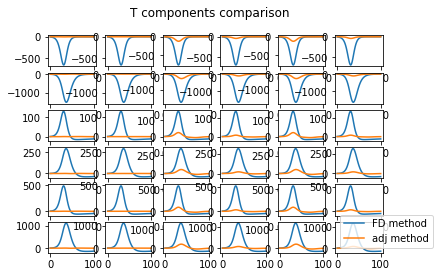

In [5]:
##################### TEST 1 : Time evol Op ####################################
def check_init_prop(dx, U):
    #x0 = np.array([2.496e-01, 7.496e-01, 2.000e-04, 2.000e-04, 2.000e-04, 2.000e-04])
    x0_pert = x0+dx
    print(x0_pert)
    estimator.set_det_model(inference_parameters)
    xd = estimator.integrate(x0, t1, t2, Nf)
    xd_pert = estimator.integrate(x0_pert, t1, t2, Nf)
    ## compare with T's
    dxpred = np.einsum('kij,j->ki', U, dx)
    return dxpred, xd_pert-xd

xd = estimator.integrate(x0, t1, t2, Nf)
To = np.zeros( (steps, M*nClass, M*nClass))
Tn = np.zeros( (steps, M*nClass, M*nClass))
for k,ts in enumerate(time_points+dt):
    xf=xd[k]
    estimator._obtain_time_evol_op(x0, xf, t1, ts)
    To[k,:,:] = estimator.U
    Tn[k,:,:] = estimator._obtain_time_evol_op_2(x0, xf, t1, ts)

fig, axs = plt.subplots(M*nClass,M*nClass)
axs = np.ndarray.flatten(axs)
for k,ax in enumerate(axs):
    kx = k //(M*nClass)
    ky = k % (M*nClass)
    ax.plot(To[:,kx,ky], label="FD method")
    ax.plot(Tn[:,kx,ky], label="adj method")
plt.suptitle("T components comparison")
plt.legend()
plt.show()

[1.2479996e+04 3.7480002e+04 1.0002000e+01 1.0001000e+01 1.0000500e+01
 1.0000500e+01]
[1.2479996e+04 3.7480002e+04 1.0002000e+01 1.0001000e+01 1.0000500e+01
 1.0000500e+01]


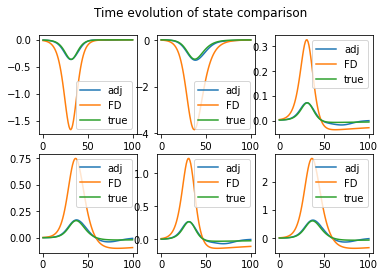

In [6]:
dx = np.array([-200, 100, 100, 50, 25,25])/N
dxo, dxp_true = check_init_prop(dx,To)
dxn, dxp_true = check_init_prop(dx,Tn)
fig, axs = plt.subplots(M, nClass)
axs = np.ndarray.flatten(axs)
for k,ax in enumerate(axs):
    ax.plot(dxn[:,k], label='adj')
    ax.plot(dxo[:,k], label='FD')
    ax.plot(dxp_true[:,k], label='true')
    ax.legend()
plt.suptitle("Time evolution of state comparison")
plt.show()

In [7]:
################## TEST 2 : Sympy functions initialisation ################################
x =sympy.Matrix( sympy.symarray('x', (nClass, M)))
b=estimator.construct_B_spp(x)
a=estimator.construct_A_spp(x)
j=estimator.construct_J_spp(x)
p =sympy.Matrix( sympy.symarray('p', (nParams, M)))
#print(a,b,j)

In [8]:
################## TEST 3 : Derivatives of mean trajectories ################################
## NOTE: this is a bit slow
def dtrajdp_FD(param_str, scale=1e5):
    """ Calculates deribvative of mean traj using finite difference (FD)"""
    Paramvalue = inference_parameters[param_str]
    dp = Paramvalue/scale

    inference_parameters[param_str] +=dp
    est_obj = pyross.inference.Spp(model_spec, inference_parameters, M, Ni)
    est_obj.set_params(inference_parameters)
    est_obj.set_contact_matrix(contactMatrix)
    xd_p = est_obj.integrate(x0, t1, t2, Nf) 
    
    inference_parameters[param_str] -= 2*dp
    est_obj = pyross.inference.Spp(model_spec, inference_parameters, M, Ni)
    est_obj.set_params(inference_parameters)
    est_obj.set_contact_matrix(contactMatrix)
    xd_m = est_obj.integrate(x0, t1, t2, Nf) ## wasn't updating in an intuitive way for me, so have just reinitialised

    inference_parameters[param_str] +=dp
    return xd_p, xd_m, dp

keys = np.ones((nParams,M), dtype=int)
det_model=estimator.set_det_model(inference_parameters)
nSamples=4
nBlock=steps//(nSamples-1)

In [9]:
dtraj = np.zeros((nSamples, nParams*M, M*nClass))
for k, ts in enumerate(time_points[1::nBlock]):
    dmean = estimator.dmudp(x0, t1, ts, steps, contactMatrix, full_output=True)
    dtraj[k,:,:] = dmean


Looking for saved functions...
Loaded.
0 0.05
0 1.7000000000000002
0 3.35
0 5.0


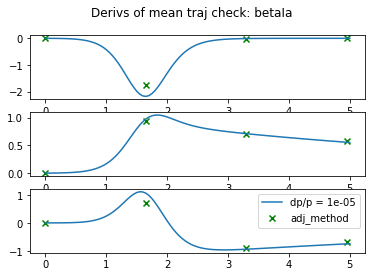

In [10]:
## Find derivatives wrt the params via finite difference
scale=1e5
xp, xm, dp = dtrajdp_FD('betaIa', scale=scale)
dxdp=(xp-xm)/(2*dp)


fig, axs = plt.subplots(nClass)
axs = np.ndarray.flatten(axs)
for k, axx in enumerate(axs):
    axx.plot(time_points, dxdp[:,2*k]/N, label=f"dp/p = {1/scale}")
    axx.scatter(time_points[::nBlock], dtraj[:,0,2*k]/N, marker='x', color='green', label=f"adj_method")
plt.suptitle("Derivs of mean traj check: betaIa")
plt.legend()
plt.show()

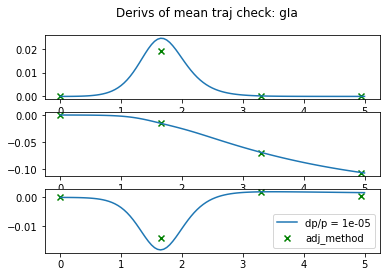

In [11]:
## Find derivatives wrt the params via finite difference
scale=1e5
xp, xm, dp = dtrajdp_FD('gIa', scale=scale)
dxdp=(xp-xm)/(2*dp)

fig, axs = plt.subplots(nClass)
axs = np.ndarray.flatten(axs)
for k, axx in enumerate(axs):
    axx.plot(time_points, dxdp[:,2*k]/N, label=f"dp/p = {1/scale}")
    axx.scatter(time_points[::nBlock], dtraj[:,4,2*k]/N, marker='x', color='green', label=f"adj_method")
plt.suptitle("Derivs of mean traj check: gIa")
plt.legend()
plt.show()

In [12]:
## Derivatives of invcov
steps=21
keys = np.ones((nParams,M), dtype=int)
det_model=estimator.set_det_model(inference_parameters)
dinvcovdp = estimator.dfullinvcovdp(x0, t1, t2, steps, contactMatrix)

0 0.0
0 0.25
0 0.5
0 0.75
0 1.0
0 1.25
0 1.5
0 1.75
0 2.0
0 2.25
0 2.5
0 2.75
0 3.0
0 3.25
0 3.5
0 3.75
0 4.0
0 4.25
0 4.5
0 4.75
0 5.0


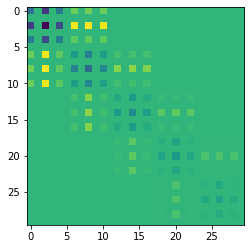

In [13]:
a=dinvcovdp[4]
plt.imshow(a[30:60, 30:60]) ## some block - verfifies block diag and symmetry